<a href="https://colab.research.google.com/github/sayanbanerjee32/TSAI_ERAv2_S8/blob/main/S8_GN_SayanBanerjee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all required packages including local files

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

import matplotlib.pyplot as plt

#import from local modules
from utils import train, test, get_device, plot_accuracy_losses, plot_top_loss
from models import NetS8GN as Net

# Check if GPU available

In [ ]:
# CUDA? - call get_device function defined in utils.py
is_cuda, device = get_device()

CUDA Available? True


# Visualising Train data

# Dataset and Creating Train/Test Split

In [ ]:
train_data_raw = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:03<00:00, 48417780.53it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# train data shape
print(train_data_raw.data.shape)
# train data mean
print(train_data_raw.data.mean(axis=(0,1,2))/255)
# train data standard deviation
print(train_data_raw.data.std(axis=(0,1,2))/255)

(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


# Dataloader Arguments & Test/Train Dataloaders

In [ ]:
# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if is_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader_raw = torch.utils.data.DataLoader(train_data_raw, **dataloader_args)

class_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Data Visualization

torch.Size([128, 3, 32, 32])
torch.Size([128])


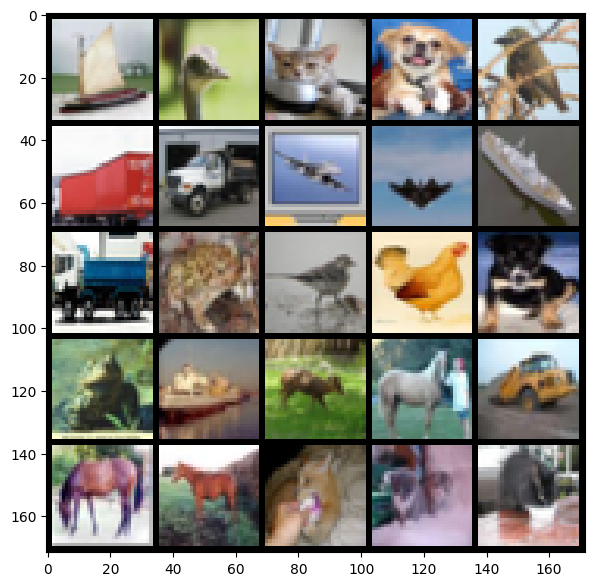

In [ ]:
dataiter = iter(train_loader_raw)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Create a grid of images
grid = torchvision.utils.make_grid(images[:25], nrow=5)

# Display the grid
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.show()

In [ ]:
# how labels look like
print(' '.join(f'{class_labels[labels[j]]:5s}' for j in range(len(labels[:25]))))

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat  


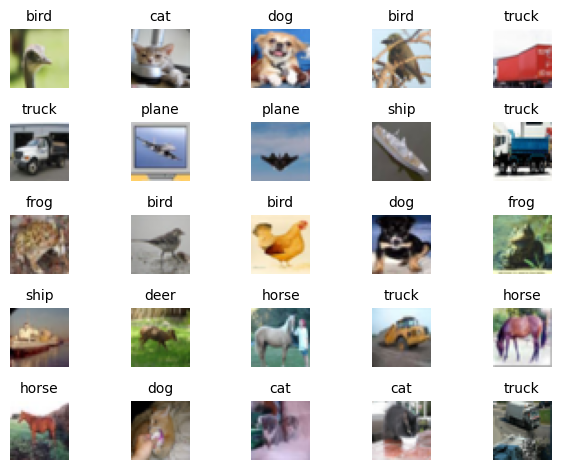

In [ ]:
figure = plt.figure()
rows, cols = 5, 5
for index in range(1, cols * rows  + 1):
    plt.subplot(rows, cols, index)
    plt.title(class_labels[labels[index]],fontsize = 10)
    plt.axis('off')
    plt.imshow(images[index].permute(1, 2, 0))
figure.tight_layout()
plt.show()

# Train and Test transformations

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                        transforms.RandomApply([transforms.RandomResizedCrop(size=(32, 32))], p=0.1),
                                        transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784)),
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784))
                                       ])

# Dataset and Creating Train/Test Split

In [ ]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders

In [ ]:
# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

## Data Visualization

# Training

In [ ]:
# visualise model parameters
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             256
             ReLU-10            [-1, 8, 32, 32]               0
        GroupNorm-11            [-1, 8, 32, 32]              16
          Dropout-12            [-1, 8, 32, 32]               0
        MaxPool2d-13            [-1, 8, 16, 16]               0
           Conv2d-14           [-1, 16,

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9) # reduce learning rate, loss not converging
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer  = optimizer,
                                                 mode = 'min',
                                                 factor = 0.1,
                                                 min_lr = 0.0001,
                                                 threshold_mode  = 'rel',
                                                 threshold = 0.0001,
                                                 patience  = 2,
                                                 verbose = True)
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    # call train function from utils.py
    trn_acc, trn_loss = train(model, device, train_loader, optimizer, criterion)
    # accumulate train accuracies and test losses for visualisation
    train_acc.append(trn_acc)
    train_losses.append(trn_loss)

    # call test function from utils.py
    tst_acc, tst_loss = test(model, device, test_loader, criterion)
    # accumulate test accuracies and test losses for visualisation
    test_acc.append(tst_acc)
    test_losses.append(tst_loss)

    scheduler.step(tst_loss)
    # print(f"learning rate={optimizer.state_dict()['param_groups'][0]['lr']}, trn_loss = {trn_loss}")



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=1.6676 Batch_id=390 Accuracy=30.88: 100%|██████████| 391/391 [00:23<00:00, 16.71it/s]


Test set: Average loss: 1.6607, Accuracy: 3860/10000 (38.60%)

Epoch 2


Train: Loss=1.7723 Batch_id=390 Accuracy=40.14: 100%|██████████| 391/391 [00:23<00:00, 16.92it/s]


Test set: Average loss: 1.6185, Accuracy: 4137/10000 (41.37%)

Epoch 3


Train: Loss=1.3882 Batch_id=390 Accuracy=45.28: 100%|██████████| 391/391 [00:22<00:00, 17.10it/s]


Test set: Average loss: 1.3495, Accuracy: 5109/10000 (51.09%)

Epoch 4


Train: Loss=1.4135 Batch_id=390 Accuracy=48.95: 100%|██████████| 391/391 [00:23<00:00, 16.90it/s]


Test set: Average loss: 1.2565, Accuracy: 5462/10000 (54.62%)

Epoch 5


Train: Loss=1.2118 Batch_id=390 Accuracy=52.44: 100%|██████████| 391/391 [00:23<00:00, 16.49it/s]


Test set: Average loss: 1.2175, Accuracy: 5626/10000 (56.26%)

Epoch 6


Train: Loss=1.3091 Batch_id=390 Accuracy=55.00: 100%|██████████| 391/391 [00:23<00:00, 16.37it/s]


Test set: Average loss: 1.2537, Accuracy: 5484/10000 (54.84%)

Epoch 7


Train: Loss=1.0636 Batch_id=390 Accuracy=57.01: 100%|██████████| 391/391 [00:24<00:00, 16.17it/s]


Test set: Average loss: 1.0835, Accuracy: 6108/10000 (61.08%)

Epoch 8


Train: Loss=1.2451 Batch_id=390 Accuracy=58.51: 100%|██████████| 391/391 [00:24<00:00, 16.17it/s]


Test set: Average loss: 1.0966, Accuracy: 6104/10000 (61.04%)

Epoch 9


Train: Loss=1.1982 Batch_id=390 Accuracy=59.79: 100%|██████████| 391/391 [00:24<00:00, 16.01it/s]


Test set: Average loss: 1.0876, Accuracy: 6211/10000 (62.11%)

Epoch 10


Train: Loss=1.1447 Batch_id=390 Accuracy=61.22: 100%|██████████| 391/391 [00:24<00:00, 15.96it/s]


Test set: Average loss: 0.9820, Accuracy: 6519/10000 (65.19%)

Epoch 11


Train: Loss=1.2217 Batch_id=390 Accuracy=61.87: 100%|██████████| 391/391 [00:24<00:00, 15.97it/s]


Test set: Average loss: 1.0506, Accuracy: 6283/10000 (62.83%)

Epoch 12


Train: Loss=0.9666 Batch_id=390 Accuracy=62.85: 100%|██████████| 391/391 [00:24<00:00, 16.18it/s]


Test set: Average loss: 0.9429, Accuracy: 6611/10000 (66.11%)

Epoch 13


Train: Loss=0.8201 Batch_id=390 Accuracy=63.30: 100%|██████████| 391/391 [00:24<00:00, 16.08it/s]


Test set: Average loss: 1.0175, Accuracy: 6529/10000 (65.29%)

Epoch 14


Train: Loss=0.8221 Batch_id=390 Accuracy=63.84: 100%|██████████| 391/391 [00:24<00:00, 16.13it/s]


Test set: Average loss: 0.9557, Accuracy: 6597/10000 (65.97%)

Epoch 15


Train: Loss=1.1551 Batch_id=390 Accuracy=64.79: 100%|██████████| 391/391 [00:24<00:00, 16.18it/s]


Test set: Average loss: 1.0526, Accuracy: 6398/10000 (63.98%)

Epoch 16


Train: Loss=0.8554 Batch_id=390 Accuracy=67.89: 100%|██████████| 391/391 [00:24<00:00, 16.11it/s]


Test set: Average loss: 0.8548, Accuracy: 6994/10000 (69.94%)

Epoch 17


Train: Loss=0.8745 Batch_id=390 Accuracy=68.51: 100%|██████████| 391/391 [00:24<00:00, 16.13it/s]


Test set: Average loss: 0.8753, Accuracy: 6945/10000 (69.45%)

Epoch 18


Train: Loss=0.9163 Batch_id=390 Accuracy=68.68: 100%|██████████| 391/391 [00:24<00:00, 16.07it/s]


Test set: Average loss: 0.8650, Accuracy: 6991/10000 (69.91%)

Epoch 19


Train: Loss=0.7967 Batch_id=390 Accuracy=69.27: 100%|██████████| 391/391 [00:24<00:00, 16.17it/s]


Test set: Average loss: 0.8320, Accuracy: 7059/10000 (70.59%)

Epoch 20


Train: Loss=0.9809 Batch_id=390 Accuracy=69.10: 100%|██████████| 391/391 [00:24<00:00, 16.19it/s]


Test set: Average loss: 0.8269, Accuracy: 7077/10000 (70.77%)



In [ ]:
# final learning rate
scheduler.get_last_lr()

[0.010000000000000002]

## Visualise training and test losses and accuracies

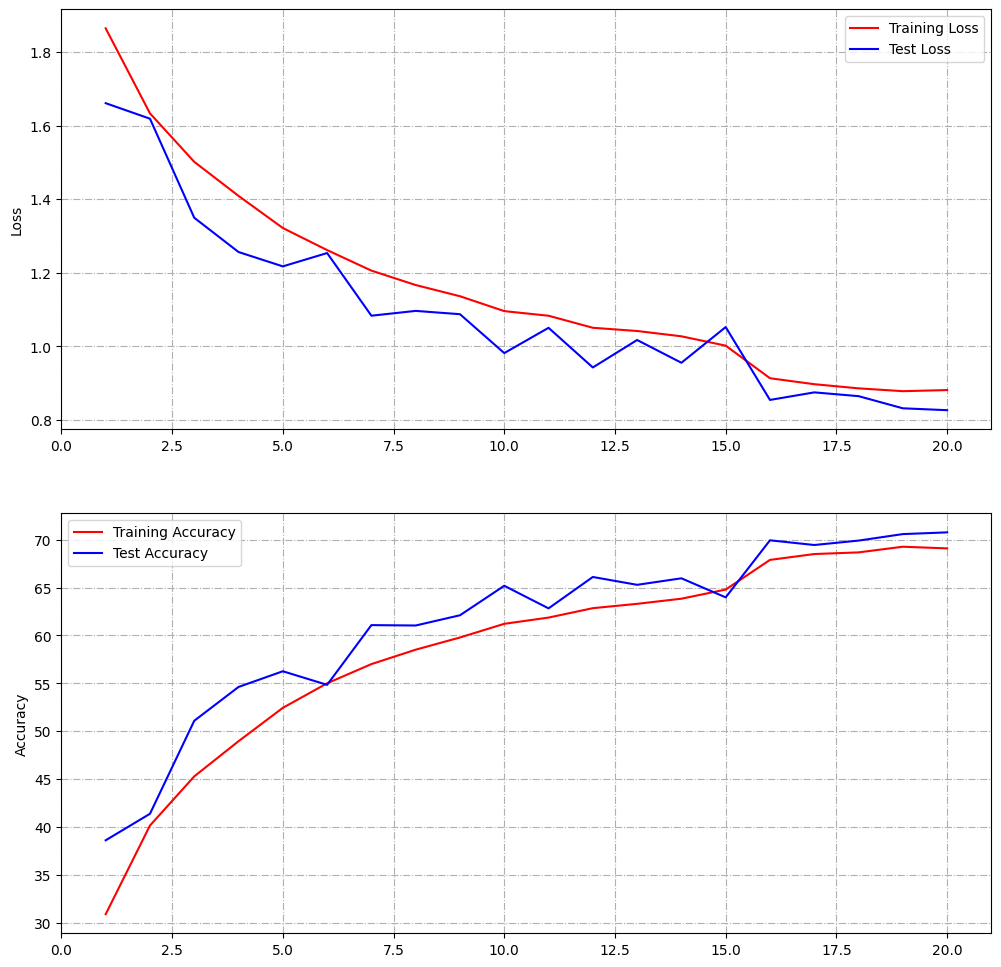

In [ ]:
## use function from utils.py
plot_accuracy_losses(train_losses, train_acc, test_losses, test_acc, num_epochs)

## Error analysis

total wrong predictions: 2923


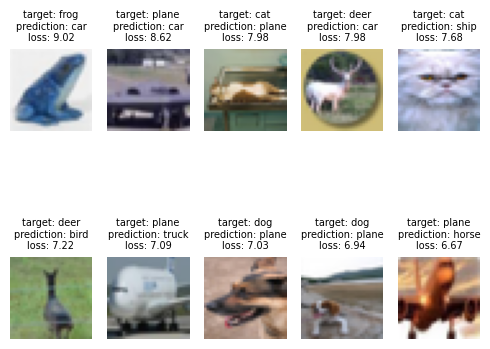

In [ ]:
incr_groups_df = plot_top_loss(model, device, test_loader, criterion,
                               label_names = class_labels, img_rows=2, img_cols = 5)

In [ ]:
incr_groups_df.loc[incr_groups_df.image > 1]

,target,prediction,loss,image
20,cat,dog,1.443714,185
37,dog,cat,1.403530,153
31,deer,horse,1.718425,139
26,deer,bird,1.943836,127
69,plane,ship,1.536923,103
...,...,...,...,...
34,deer,truck,3.638801,3
76,ship,frog,1.897816,2
12,car,frog,1.930385,2
65,plane,deer,4.275975,2
